In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('RRBSEpigeneticClockTrainer').setLevel(logging.DEBUG)

In [6]:
from epigenetic_clock_assignment.rrbs_epigenetic_clock_assignment import RRBSEpigeneticClockTrainer

trainer = RRBSEpigeneticClockTrainer(meta_csv_filepath='data/MetaPolished.csv',
                                    features_csv_filepath='data/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv',
                                    features_pickle_cache_filepath='data/features_cache.pickle')

X, y = trainer.load()



DEBUG:RRBSEpigeneticClockTrainer:__init__
DEBUG:RRBSEpigeneticClockTrainer:load
DEBUG:RRBSEpigeneticClockTrainer:loading features from cache file "data/features_cache.pickle"...
DEBUG:RRBSEpigeneticClockTrainer:loaded; shape=(182, 5201794)
DEBUG:RRBSEpigeneticClockTrainer:joining based on ID
DEBUG:RRBSEpigeneticClockTrainer:joined; shape=(182, 5201797)
DEBUG:RRBSEpigeneticClockTrainer:creating y
DEBUG:RRBSEpigeneticClockTrainer:creating X
DEBUG:RRBSEpigeneticClockTrainer:loaded


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
print('X', X_train.shape, X_test.shape)
print('Y', y_train.shape, y_test.shape)

model = trainer.train(X_train=X_train,y_train=y_train, cv_fold=3, parallel_jobs=1)


X (145, 5201794) (37, 5201794)
Y (145,) (37,)


lambda max
lambda:  0.10595674315380874
median_absolute_error 2.009663377426392
explained_variance_score 0.8405571101674888
root_mean_squared_error 3.7573388893218365
r2 0.8333046844155799
t-test Ttest_indResult(statistic=-0.40955653709675455, pvalue=0.6833472052283336)
smstats r2 0.8767950207792831
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     249.1
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           1.74e-17
Time:                        11:02:06   Log-Likelihood:                -85.044
No. Observations:                  37   AIC:                             174.1
Df Residuals:                      35   BIC:                             177.3
Df Model:                           1                              

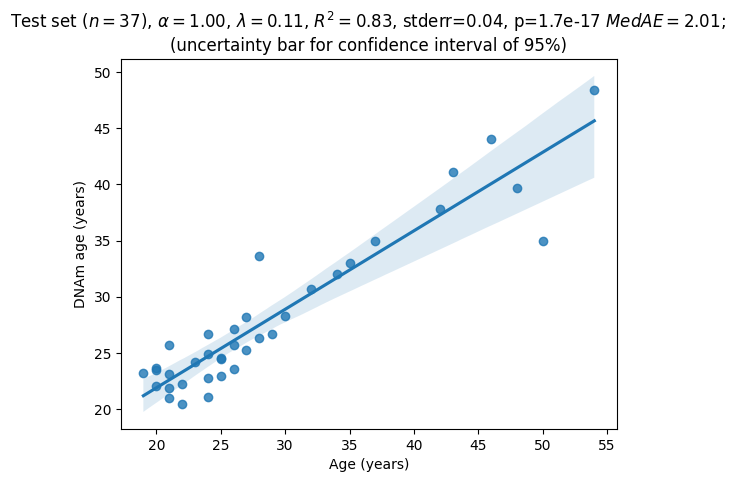

lambda best
lambda:  0.1851624178336005
median_absolute_error 1.8973212061423652
explained_variance_score 0.8422398350196423
root_mean_squared_error 3.7351451529093542
r2 0.8352681301865521
t-test Ttest_indResult(statistic=-0.4025388423288381, pvalue=0.6884801669511251)
smstats r2 0.8814280117332403
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     260.2
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           8.86e-18
Time:                        11:02:30   Log-Likelihood:                -84.079
No. Observations:                  37   AIC:                             172.2
Df Residuals:                      35   BIC:                             175.4
Df Model:                           1                              

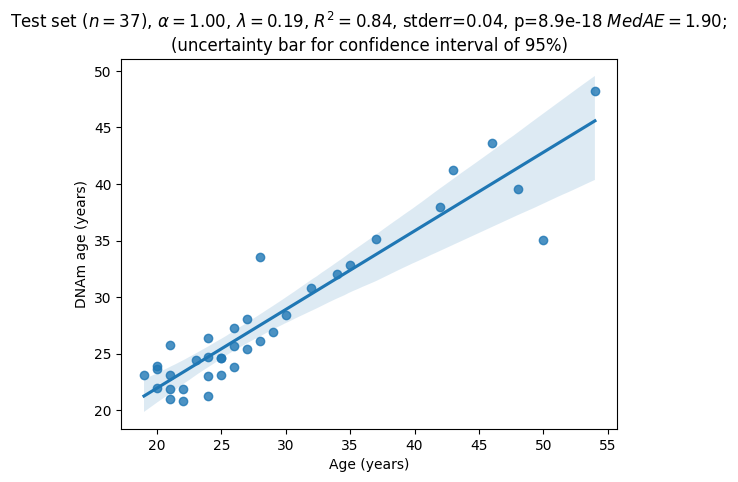

In [8]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, median_absolute_error
import numpy as np
import sigfig
import glmnet
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.feature_selection import chi2 

def calculate_stats(X_test, y_test, lamb: float, model: glmnet.ElasticNet):
    y_pred = trainer.predict(X=X_test, lamb=lamb)
    
    print('lambda: ', lamb)
    
    medae = median_absolute_error(y_true=y_test, y_pred=y_pred)
    
    print('median_absolute_error', medae)
    print('explained_variance_score', explained_variance_score(y_test, y_pred))
    print('root_mean_squared_error', np.sqrt(mean_squared_error(y_test, y_pred)))
    
    r2 = r2_score(y_test, y_pred)
    print('r2', r2)
    
    independent_samples_t_test = stats.ttest_ind(y_pred, y_test, equal_var=True)
    print('t-test', independent_samples_t_test)
    
    sm_y_test = sm.add_constant(y_test) # column of 1s
    sm_model = sm.OLS(y_pred, sm_y_test).fit()
    print("smstats r2", sm_model.rsquared)
    print(sm_model.summary())
    print('pvalues', sm_model.pvalues)
    
    #chi2_scores, chi2_pvalues = chi2(y_pred, y_test)
    #print('chi2_scores, chi2_pvalues', chi2_scores, chi2_pvalues)
    
    print('glmnet r2', model.score(X=X_test, y=y_test, lamb=lamb))
    
    linregress_result = stats.linregress(y_test, y_pred)
    p_value = sigfig.round(linregress_result.pvalue, sigfigs=2)
    standard_error = linregress_result.stderr
    
    print('stats linregress', linregress_result)
    
    
    # https://seaborn.pydata.org/tutorial/error_bars.html
    sns.regplot(x = y_test, y = y_pred, ci=99, label='alma', n_boot=5000).set(title=f'Test set ($n={np.shape(X_test)[0]}$), $\\alpha={model.alpha:.2f}$, $\lambda={lamb:.2f}$, $R^2={r2:.2f}$, stderr={standard_error:.2f}, p={p_value} $MedAE={medae:.2f}$; \n(uncertainty bar for confidence interval of 95%)', xlabel='Age (years)', ylabel='DNAm age (years)')
    plt.show()

print('lambda max')
calculate_stats(X_test=X_test, y_test=y_test,  lamb=model.lambda_max_, model=model)
print('lambda best')
calculate_stats(X_test=X_test, y_test=y_test,  lamb=model.lambda_best_[0], model=model)


In [ ]:
#import numpy as np

#arr = df.to_numpy() 
#with open('korte.pickle', 'wb') as f:
#    np.save(f, arr)

In [ ]:
#import datatable as dt

#dtt = dt.Frame(computed)